100%|██████████| 362M/362M [00:07<00:00, 48.5MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/aravinii/duolingo-spaced-repetition-data/versions/1
Accuracy: 0.704


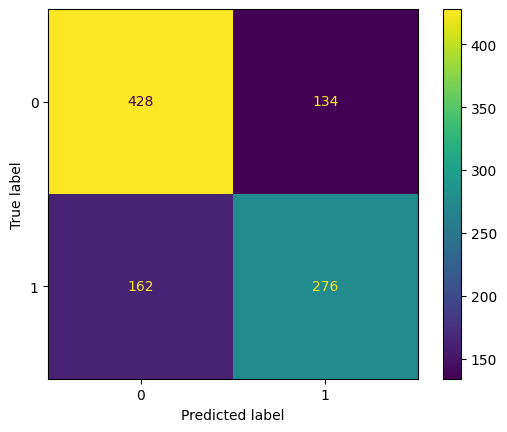

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aravinii/duolingo-spaced-repetition-data")

print("Path to dataset files:", path)

# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Cell 2: Generate synthetic dataset
np.random.seed(42)

n_users = 50
n_cards = 100
n_samples = 5000

data = pd.DataFrame({
    'user_id': np.random.randint(1, n_users+1, n_samples),
    'card_id': np.random.randint(1, n_cards+1, n_samples),
    'time_since_last_review': np.random.exponential(scale=24, size=n_samples), # hours
    'times_reviewed': np.random.randint(1, 10, n_samples),
    'last_attempt_correct': np.random.randint(0,2,n_samples),
    'card_difficulty': np.random.uniform(0.3,0.9,n_samples),
})

# Simulate target using some hidden pattern + noise
prob_correct = (
    0.5
    + 0.1 * data['last_attempt_correct']
    + 0.05 * data['times_reviewed']
    - 0.01 * data['time_since_last_review']
    - 0.2 * data['card_difficulty']
)
prob_correct = np.clip(prob_correct, 0, 1)
data['was_correct'] = np.random.binomial(1, prob_correct)

data.head()

# Cell 3: Encode categorical features
le_user = LabelEncoder()
le_card = LabelEncoder()
data['user_id_enc'] = le_user.fit_transform(data['user_id'])
data['card_id_enc'] = le_card.fit_transform(data['card_id'])

features = ['user_id_enc', 'card_id_enc', 'time_since_last_review',
            'times_reviewed', 'last_attempt_correct', 'card_difficulty']
X = data[features]
y = data['was_correct']

# Cell 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cell 5: Train model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# Cell 6: Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [2]:
data.head()

,user_id,card_id,time_since_last_review,times_reviewed,last_attempt_correct,card_difficulty,was_correct,user_id_enc,card_id_enc
0,39,45,2.606247,7,0,0.707318,1,38,44
1,29,17,31.435575,8,1,0.767459,1,28,16
2,15,85,11.755003,1,0,0.600558,1,14,84
3,43,66,36.824561,4,1,0.518300,1,42,65
4,8,6,16.296954,4,1,0.559226,1,7,5


In [3]:
# Example: single new review input
# Make sure to use the same encoding/scaling as your training data


# Suppose the model is trained and your encoders are le_user, le_card
new_input = pd.DataFrame({
    'user_id_enc': [le_user.transform([17])[0]],   # encode user_id
    'card_id_enc': [le_card.transform([42])[0]],   # encode card_id
    'time_since_last_review': [48.0],              # hours
    'times_reviewed': [5],
    'last_attempt_correct': [1],
    'card_difficulty': [0.5]
})

# Get probability of recall
probability = model.predict_proba(new_input)[:, 1][0]
print(f"Predicted probability of correct recall: {probability:.2f}")


Predicted probability of correct recall: 0.23


In [ ]:
import pickle

# Save the trained model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the user and card encoders
with open('le_user.pkl', 'wb') as f:
    pickle.dump(le_user, f)
with open('le_card.pkl', 'wb') as f:
    pickle.dump(le_card, f)

# Create and save chapter encoder (based on your database chapters)
chapters = ['Basics', 'Greetings', 'Food Signs', 'Family', 'Numbers']
le_chapter = LabelEncoder()
le_chapter.fit(chapters)
with open('le_chapter.pkl', 'wb') as f:
    pickle.dump(le_chapter, f)